**Importing Required Libraries**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

**Data Preparation**

In [100]:
fpath = './paper2023/'
fname = 'seoul_st.xlsx'
df = pd.read_excel(fpath+fname)
df
idx2019s = np.where(df['Date']=='2019-01-01')[0][0]
idx2019e = np.where(df['Date']=='2019-12-31')[0][0]

In [101]:
df = df.iloc[:,-1]
df

0       102034
1       174770
2       133830
3       114127
4       169486
         ...  
2917    137571
2918    139451
2919    139025
2920    140980
2921     96394
Name: total, Length: 2922, dtype: int64

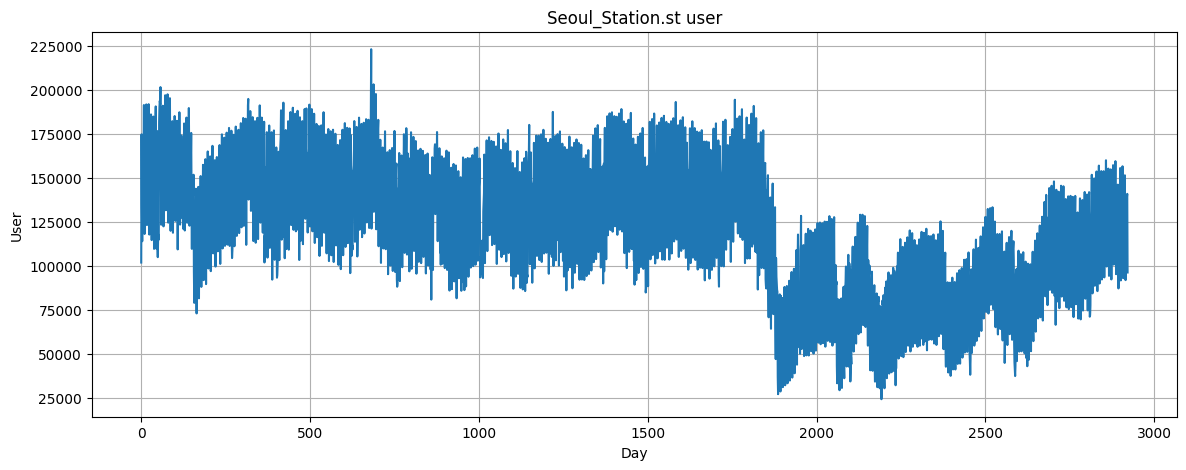

In [102]:
plt.figure(figsize=(14,5))
plt.plot(df)
plt.title('Seoul_Station.st user')
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('User')
plt.show()

In [103]:
train = df.iloc[:idx2019s].values
test = df.iloc[idx2019s:idx2019e].values

In [104]:
scaler = MinMaxScaler(feature_range=(0,1))
train_N = scaler.fit_transform(train.reshape(-1,1))

In [105]:
train_N

array([[0.19255102],
       [0.67795603],
       [0.4047422 ],
       ...,
       [0.42309438],
       [0.19863727],
       [0.53464223]])

In [106]:
train_N = torch.Tensor(train_N)
train_N

tensor([[0.1926],
        [0.6780],
        [0.4047],
        ...,
        [0.4231],
        [0.1986],
        [0.5346]])

In [107]:
train_N = torch.Tensor(train_N).view(-1)
train_N

tensor([0.1926, 0.6780, 0.4047,  ..., 0.4231, 0.1986, 0.5346])

In [108]:
WS = 365        # [1,2,3,...,24] ---> [25]  / [2,3,4,...,25] ---> [26]
X_train = [] 
y_train = []

for i in range(len(train_N)-WS):
  X_train.append(train_N[i:i+WS]) # train_N[1:25]
  y_train.append(train_N[i+WS:i+WS+1]) # train_N[25:26]

In [109]:
y_train

[tensor([0.1928]),
 tensor([0.2948]),
 tensor([0.2439]),
 tensor([0.5526]),
 tensor([0.5263]),
 tensor([0.5390]),
 tensor([0.5551]),
 tensor([0.6860]),
 tensor([0.4449]),
 tensor([0.2112]),
 tensor([0.5510]),
 tensor([0.5546]),
 tensor([0.5756]),
 tensor([0.5850]),
 tensor([0.7114]),
 tensor([0.4741]),
 tensor([0.2481]),
 tensor([0.5504]),
 tensor([0.4919]),
 tensor([0.5173]),
 tensor([0.5525]),
 tensor([0.6857]),
 tensor([0.4176]),
 tensor([0.1279]),
 tensor([0.5088]),
 tensor([0.5530]),
 tensor([0.5868]),
 tensor([0.5917]),
 tensor([0.6926]),
 tensor([0.4442]),
 tensor([0.2031]),
 tensor([0.5080]),
 tensor([0.5194]),
 tensor([0.5465]),
 tensor([0.5663]),
 tensor([0.6282]),
 tensor([0.2583]),
 tensor([0.1352]),
 tensor([0.1452]),
 tensor([0.1860]),
 tensor([0.2464]),
 tensor([0.5266]),
 tensor([0.6119]),
 tensor([0.3814]),
 tensor([0.2017]),
 tensor([0.5928]),
 tensor([0.6015]),
 tensor([0.6403]),
 tensor([0.6669]),
 tensor([0.7688]),
 tensor([0.5154]),
 tensor([0.2792]),
 tensor([0.6

**Creating LSTM Model**

In [110]:
class LSTM(nn.Module):
  def __init__(self,input_size=1,hidden_size=60,output_size=1):
    super().__init__()

    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size,hidden_size)
    self.linear = nn.Linear(hidden_size,output_size)

    self.hidden_cell = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

  def forward(self,input_seq):                         #(window_size,1,input_size)
    lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1),self.hidden_cell)
    predictions = self.linear(lstm_out.view(len(input_seq),-1))
    return predictions[-1]

model = LSTM()

In [111]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)

In [112]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience
    
    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1
    
    def is_stop(self):
        return self.patience >= self.patience_limit

**Training Stage**

In [113]:
epochs = 30

early_stop = EarlyStopping(patience=5)

for i in range(epochs):
  optimizer.zero_grad()
  model.hidden_cell = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))
  for x in X_train:
    y_pred = model(x)
  for y in y_train:
    loss = criterion(y_pred,y)
  
  
  loss.backward()
  optimizer.step()

  print(f'epoch: {i:2}, Loss: {loss.item():8.6f}')
  early_stop.step(loss.item())
  if early_stop.is_stop():
    break







epoch:  0, Loss: 0.124005
epoch:  1, Loss: 0.074937
epoch:  2, Loss: 0.033034
epoch:  3, Loss: 0.003264
epoch:  4, Loss: 0.018302
epoch:  5, Loss: 0.015504
epoch:  6, Loss: 0.003501
epoch:  7, Loss: 0.000005
epoch:  8, Loss: 0.001376
epoch:  9, Loss: 0.003700
epoch: 10, Loss: 0.005214
epoch: 11, Loss: 0.005486
epoch: 12, Loss: 0.004703


**Testing Stage**

In [114]:
preds = train_N[-WS:].tolist()

model.eval()

for i in range(30):
  seq = torch.Tensor(preds[-WS:])
  with torch.no_grad():
    preds.append(model(seq).item())

predictions = preds[:WS]

predictions

[0.1425129771232605,
 0.4757484495639801,
 0.4497750997543335,
 0.46239471435546875,
 0.5694112777709961,
 0.2858668267726898,
 0.0937696024775505,
 0.471670925617218,
 0.46628537774086,
 0.4720246195793152,
 0.4609265625476837,
 0.5500447154045105,
 0.3835738003253937,
 0.1395232379436493,
 0.4965898394584656,
 0.4706498682498932,
 0.4936601519584656,
 0.5061663389205933,
 0.6144775152206421,
 0.39409127831459045,
 0.14975374937057495,
 0.49163809418678284,
 0.4487340450286865,
 0.4172283411026001,
 0.4440558850765228,
 0.535362958908081,
 0.2620290219783783,
 0.09675934165716171,
 0.4489342272281647,
 0.4800662100315094,
 0.46420323848724365,
 0.47124379873275757,
 0.5715534687042236,
 0.33981555700302124,
 0.09093336015939713,
 0.4450702667236328,
 0.4365348517894745,
 0.4663454592227936,
 0.5032299757003784,
 0.5875298380851746,
 0.29601722955703735,
 0.08464022725820541,
 0.5348290801048279,
 0.55367511510849,
 0.6120150089263916,
 0.13965670764446259,
 0.11593236029148102,
 0.146

In [115]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions

array([[ 94535.99957001],
       [144470.00217336],
       [140577.99959779],
       [142468.99836731],
       [158505.00232887],
       [116017.00052458],
       [ 87231.99985285],
       [143859.00152004],
       [143051.99871296],
       [143912.00114548],
       [142249.00169152],
       [155603.0004245 ],
       [130657.99968356],
       [ 94087.9991129 ],
       [147593.00108349],
       [143706.00015777],
       [147153.99913037],
       [149028.0012219 ],
       [165257.99774575],
       [132234.00169033],
       [ 95621.00032818],
       [146851.00186151],
       [140422.00171137],
       [135700.99800086],
       [139720.99815518],
       [153402.99794054],
       [112445.00082737],
       [ 87680.00030996],
       [140451.99821323],
       [145117.00130838],
       [142739.99847436],
       [143794.99826491],
       [158826.00107145],
       [124101.00195467],
       [ 86807.00028645],
       [139872.99918747],
       [138594.00140125],
       [143061.0016827 ],
       [1485

In [116]:
test

array([ 89496, 148870, 148278, 168939, 128837,  92091, 148476, 151009,
       147093, 151728, 173383, 136745,  96124, 150915, 150756, 150868,
       155049, 175246, 135255,  99503, 150387, 152831, 154798, 159031,
       178369, 138899,  98472, 154040, 153223, 153953, 154456, 161604,
       114693,  85052,  87091,  89663,  92165, 141038, 156591, 126256,
        88633, 154879, 156929, 158600, 164188, 181863, 146104, 103875,
       158153, 159286, 163419, 166780, 183432, 150131, 106322, 165606,
       164379, 166560, 186557, 162831, 123195, 101524, 144308, 145204,
       149746, 158067, 179799, 142562, 104430, 156606, 153685, 155569,
       160100, 181447, 140494, 108405, 156234, 155467, 157415, 160940,
       184068, 141608, 103722, 157543, 157744, 159340, 163756, 185277,
       137209, 103551, 153095, 153518, 156859, 163030, 181798, 141950,
       110488, 155687, 154086, 154324, 161276, 180695, 156566, 103711,
       160345, 156057, 158015, 160273, 182161, 150605, 107186, 156036,
      

**Evaluation**

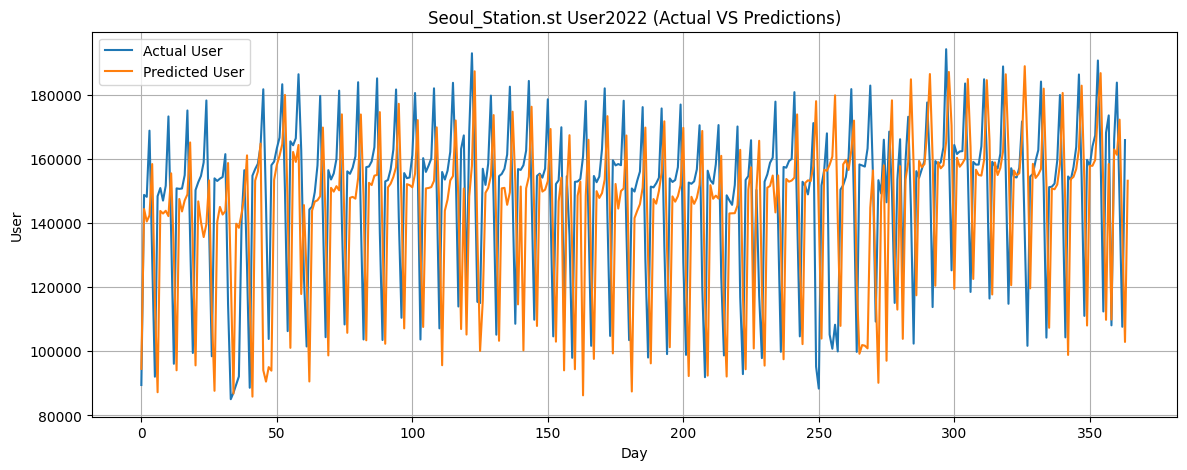

In [117]:
plt.figure(figsize=(14,5))
plt.plot(test,label='Actual User')
plt.plot(predictions, label = 'Predicted User')
plt.grid()
plt.title('Seoul_Station.st User2022 (Actual VS Predictions)')
plt.xlabel('Day')
plt.ylabel('User')
plt.legend()
plt.show()

In [118]:
mae = torch.abs(torch.tensor(predictions)-torch.tensor(test)).mean()
print('Mean Absolute Error: ',mae.item())

Mean Absolute Error:  26231.167030408702


In [120]:
TP = 0
err = 10000
for i in range(len(test)):
    for j in range(max(0, i-2), min(364, i+2)):
        if abs(test[i]-predictions[j]) <= err:
            TP += 1
            break

print('mAP =', TP/365)

mAP = 0.8684931506849315
